In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [3]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from scipy import signal
from sklearn import decomposition
from sklearn.cluster import DBSCAN
from skimage.segmentation import watershed
from behavior import get_extent, density_map, get_idxs_in_patches
from spatial import gaussian_kernel_2D, get_field_patches
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from population import unit_response_matrix, activity_at_phase

In [4]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [48]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

# showcase
selected = [
    '009266_hippoSIT_2023-04-20_08-57-39',
    '009266_hippoSIT_2023-05-04_19-47-15',
    '009266_hippoSIT_2023-04-17_17-04-17',
    '009266_hippoSIT_2023-05-23_09-18-05',
]

selected

['009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-05-23_09-18-05']

In [18]:
ft, fp = 'tSNE', 70
speed_thresh = 0.04  # m/s
bin_count = 100

## Precomputed

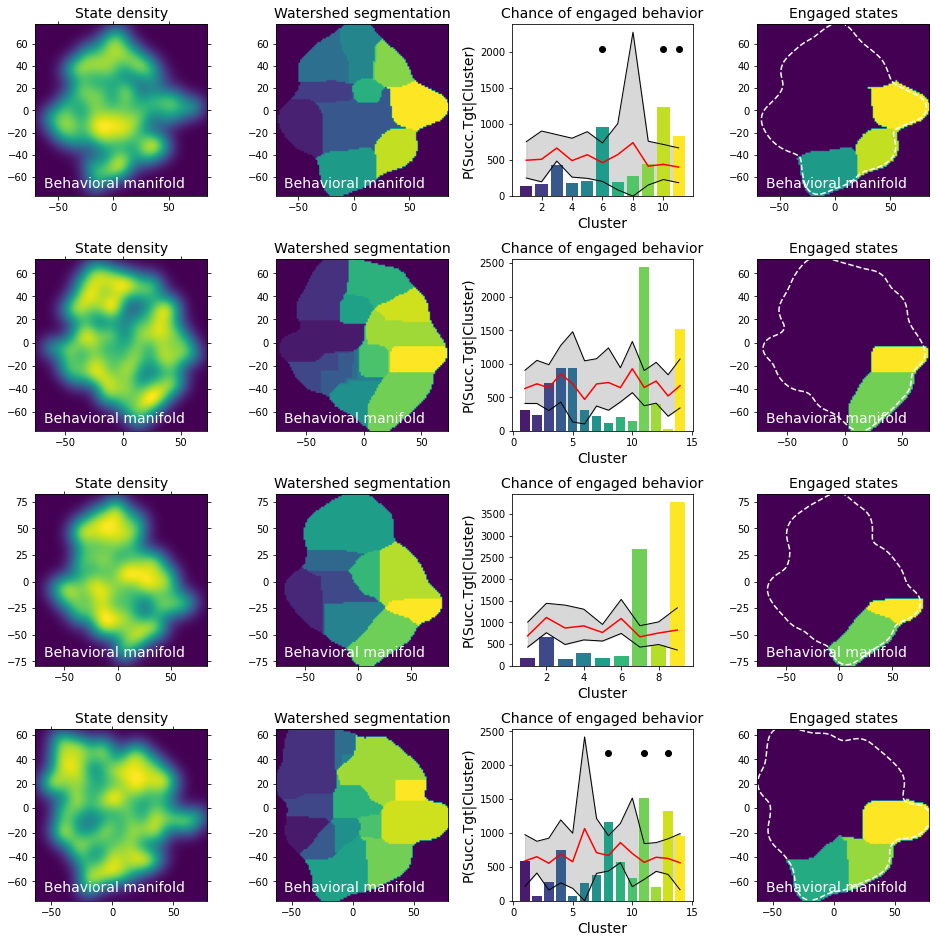

In [52]:
size = 3.3
cols = 4
cmap = 'viridis'
fig, axes = plt.subplots(len(selected), cols, figsize=(cols*size, size*len(selected)))

for i, session in enumerate(selected):
    animal = session.split('_')[0]

    s_path     = os.path.join(source, animal, session)
    meta_file  = os.path.join(source, animal, session, 'meta.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    umap_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    bMAP_seg_file = os.path.join(source, animal, session, 'analysis', 'bMAP_segmentation.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(umap_file, 'r') as f:
        fit = np.array(f[ft][str(fp)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    with h5py.File(bMAP_seg_file, 'r') as f:
        d_map = np.array(f['density_map'])
        segmentation = np.array(f['segmentation'])
        segmentation_TGT_succ = np.array(f['segmentation_TGT_succ'])
        idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])
        tgt_stats = np.array(f['tgt_stats'])
        tgt_stats_shuf = np.array(f['tgt_stats_shuf'])

    # auditory state (BGR, SIL etc.) and speed filter
    idxs_sta_ev = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_bgr_ev = np.where(events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(events[:, 1] == -1)[0]
    idxs_tri_ev = np.where( (events[:, 1] == 1) | (events[:, 1] == 2) )[0]  # in the trial
    
    idxs_succ_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_succ_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_succ_ev = np.array(idxs_succ_ev)
    
    # extent and contour
    extent = get_extent(fit, margin=margin)
    b_size = extent[1] - extent[0]
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    nMAP_cont = axes[i][0].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    axes[i][0].clear()
    
    # Scatter
#     ax = axes[i][0]
#     ax.scatter(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1], alpha=0.1, color='gray')
#     ax.scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], alpha=0.1, color='tab:blue')
#     ax.scatter(fit[idxs_succ_ev][:, 0], fit[idxs_succ_ev][:, 1], alpha=0.2, color='tab:orange')
#     #ax.scatter(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1], alpha=0.1, color='gray')
#     #ax.scatter(fit[idxs_succ_ev][:, 0], fit[idxs_succ_ev][:, 1], alpha=0.1, color='gray')
#     ax.set_xlim(extent[0], extent[1])
#     ax.set_ylim(extent[2], extent[3])
#     ax.grid()
#     ax.set_title('Neural manifold', fontsize=14)
    
    # density
    ax = axes[i][0]
    ax.imshow(d_map.T, cmap=cmap, origin='lower', extent=extent)
    ax.set_title('State density', fontsize=14)
    ax.text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Behavioral manifold', fontsize=14, color='white')

    # watershed
    ax = axes[i][1]
    axws = ax.imshow(segmentation.T, origin='lower', cmap=cmap, extent=extent)
    ax.set_title('Watershed segmentation', fontsize=14)
    colors_axws = axws.cmap(axws.norm(np.unique(segmentation.T)))
    ax.text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Behavioral manifold', fontsize=14, color='white')

    # mean and percentiles by cluster
    labels = np.unique(segmentation)[1:]
    tgt_stats_shuf_mean = tgt_stats_shuf.mean(axis=0)
    confidence_low  = np.zeros(tgt_stats_shuf.shape[1])
    confidence_high = np.zeros(tgt_stats_shuf.shape[1])
    for k, col in enumerate(tgt_stats_shuf.T):
        confidence_low[k]  = np.percentile(col, 5)
        confidence_high[k] = np.percentile(col, 95)
        
    idxs_tgt_stats_l = tgt_stats < confidence_high
    idxs_tgt_stats_h = tgt_stats > confidence_high
    clus_h = (np.arange(len(labels))+1)[idxs_tgt_stats_h]  # ids of engaged clusters
        
    ax = axes[i][2]
    ax.bar(labels[idxs_tgt_stats_l], tgt_stats[idxs_tgt_stats_l], color=colors_axws[1:][idxs_tgt_stats_l])
    ax.bar(labels[idxs_tgt_stats_h], tgt_stats[idxs_tgt_stats_h], color=colors_axws[1:][idxs_tgt_stats_h])
    ax.plot(labels, tgt_stats_shuf.mean(axis=0), color='red')
    ax.plot(labels, confidence_low, color='black', lw=1)
    ax.plot(labels, confidence_high, color='black', lw=1)
    ax.fill_between(labels, confidence_low, confidence_high, color='grey', alpha=0.3)
    ax.scatter(clus_h, np.ones(len(clus_h)) * confidence_high.max() * 0.9, color='black')
    ax.set_ylabel('P(Succ.Tgt|Cluster)', fontsize=14)
    ax.set_xlabel('Cluster', fontsize=14)
    ax.set_title('Chance of engaged behavior', fontsize=14)
    
        
    # seleted areas by TGT success
    ax = axes[i][3]
    ax.imshow(segmentation_TGT_succ.T, origin='lower', cmap=cmap, extent=extent)
    #ax.scatter(fit[idxs_tgt_succ_state_ev][:, 0], fit[idxs_tgt_succ_state_ev][:, 1], alpha=0.2)
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    #ax.grid()
    ax.set_title('Engaged states', fontsize=14)
    ax.text(extent[0] + 0.05*b_size, extent[2] + 0.05*b_size, 'Behavioral manifold', fontsize=14, color='white')
    
    # contour
    for path in nMAP_cont.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], color='white', ls='--')
    
fig.tight_layout()

In [53]:
fig.savefig(os.path.join(rep_path, '%s_bMAP_segmentation.png' % sessions[0][-19:-6]), dpi=300)

## Playground

In [12]:
# test bMAP resolution (events space)
for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    state_file = os.path.join(source, animal, session, 'analysis', 'state_idxs.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        fit = np.array(f[fit_type][str(fit_parm)])
        
    print(len(events), len(fit))

9599 9599
9599 9599
9599 9599
9599 9599


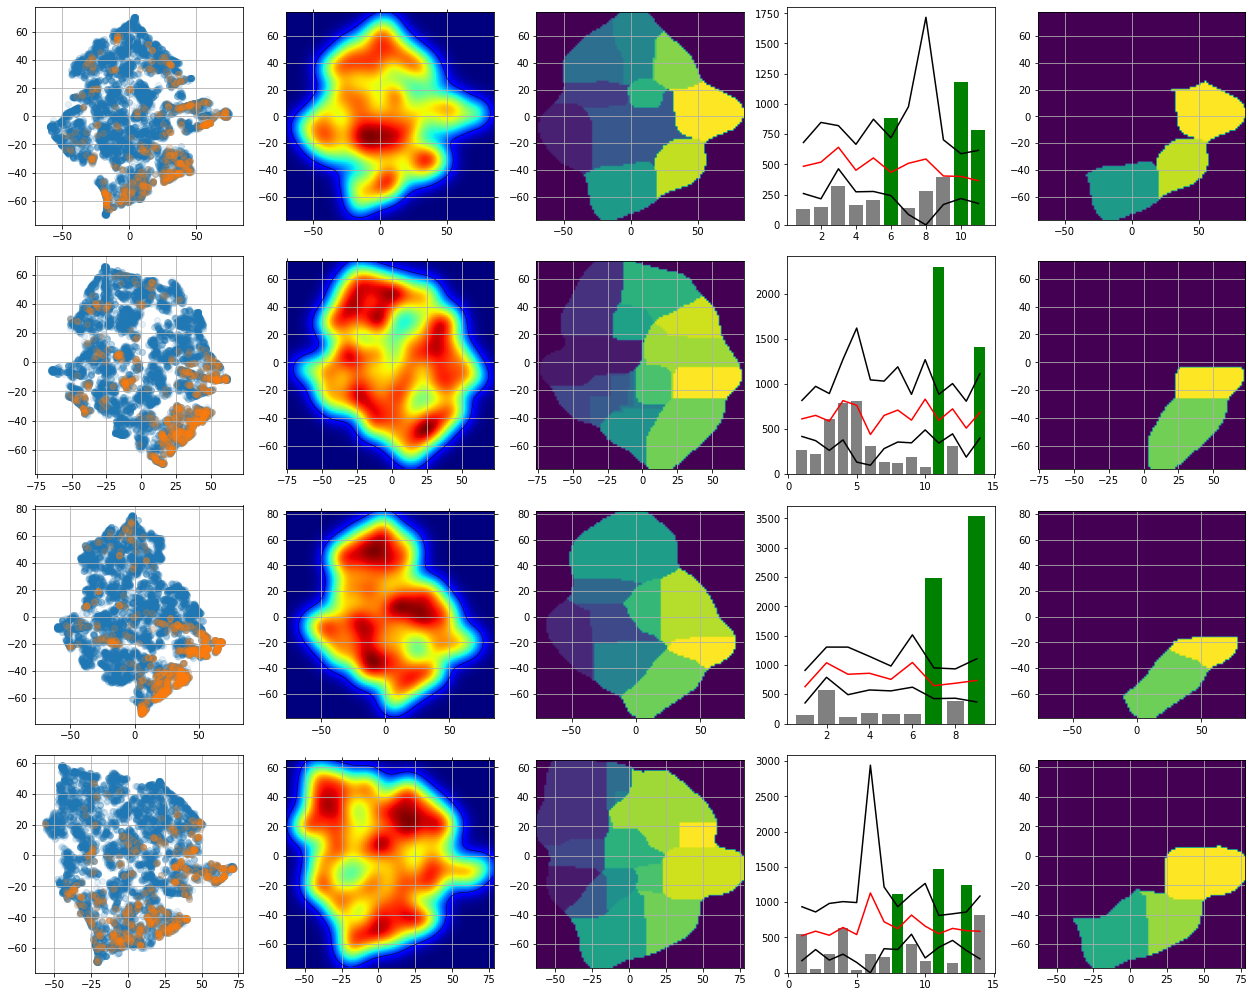

In [13]:
cmaps  = ['Blues', 'Reds']
rows = len(selected)
cols = 5
size = 3.5
fig, axes = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

for i, session in enumerate(selected):
    animal = session.split('_')[0]
    s_path           = os.path.join(source, animal, session)
    meta_file        = os.path.join(source, animal, session, 'meta.h5')
    moseq_class_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    desc_file  = os.path.join(source, animal, session, 'descendants.h5')
    
    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(moseq_class_file, 'r') as f:
        idxs_srm_tl = np.array(f['idxs_srm_tl'])
        fit = np.array(f[fit_type][str(fit_parm)])
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
        
    idxs_srm_succ = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_succ += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
    idxs_srm_fail = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 0]:
        tl_l, tl_r = tgt_rec[2], tgt_rec[3]
        idxs_srm_fail += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
        
    idxs_sta_ev  = np.where(speed[events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
    idxs_run_ev  = np.where(speed[events[:, 2].astype(np.int32)] > speed_thresh)[0]  # define speed filter here
    idxs_srm_sta = np.unique(np.round(idxs_sta_ev/2).astype(np.int32))  # TODO: bring behavior to the same sampling!
    idxs_srm_run = np.unique(np.round(idxs_sta_ev/2).astype(np.int32))  # TODO: bring behavior to the same sampling!
    idxs_srm_bgr = np.where(tl[idxs_srm_tl][:, 6] == 1)[0]
    idxs_srm_sil = np.where(tl[idxs_srm_tl][:, 6] == 0)[0]

    sigma = 0.12
    margin = 5
    extent = get_extent(fit, margin=margin)
    b_size = extent[1] - extent[0]
    
    # fit whole contours
    d_map  = density_map(fit, extent, sigma=sigma, bin_count=100)
    levels = np.linspace(0.15*d_map.max(), d_map.max(), 2)
    CS_fit = axes[i][1].contour(d_map.T, levels, origin='lower', linewidths=2, extent=extent)
    axes[i][1].clear()  # clear axes from original contours
    
    # scatter fit
    ax = axes[i][0]
    ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1)
    ax.scatter(fit[idxs_srm_succ][:, 0], fit[idxs_srm_succ][:, 1], alpha=0.2)
    #ax.scatter(fit[idxs_srm_fail][:, 0], fit[idxs_srm_fail][:, 1], alpha=0.2, color='red')
    
    # density map
    ax = axes[i][1]
    ax.imshow(d_map.T, cmap='jet', origin='lower', extent=extent)
    for path in CS_fit.collections[0].get_paths():
        verts = path.vertices
        ax.plot(verts[:,0], verts[:,1], lw=0.5, color='black')

    # watershed
    mask = d_map > 0.1*d_map.max()
    fit_labels = watershed(-d_map, mask=mask)
    
    ax = axes[i][2]
    ax.imshow(fit_labels.T, origin='lower', extent=extent)
    
    # TGT cluster stats
    labels = np.unique(fit_labels)[1:]
    fit_area = (fit_labels > 0).sum()
    label_areas = [(fit_labels == x).sum()/fit_area for x in labels]
    clu_tgt_counts = np.zeros(len(labels))
    x_bins = np.linspace(extent[0], extent[1], fit_labels.shape[0]+1)
    y_bins = np.linspace(extent[2], extent[3], fit_labels.shape[1]+1)

    # collecting label counts
    for record in fit[idxs_srm_succ]:
        x_bin_idx = np.where(x_bins > record[0])[0][0] - 1
        y_bin_idx = np.where(y_bins > record[1])[0][0] - 1

        curr_label = fit_labels[x_bin_idx, y_bin_idx]
        clu_tgt_counts[curr_label-1] += 1
    tgt_stats = clu_tgt_counts/label_areas

    # shuffle TGT and conf intervals
    iter_count = 100
    tgt_stats_shuf = np.zeros([iter_count, len(labels)])
    tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
    for k in range(iter_count):
        idxs_srm_succ_shuf = []
        clu_tgt_counts = np.zeros(len(labels))
        
        tgt_mx_succ_shuf = tgt_mx_succ.copy()
        rand_shift = np.random.randint(len(tl))
        tgt_mx_succ_shuf[:, 2] = np.mod(tgt_mx_succ[:, 2] + rand_shift, len(tl))
        tgt_mx_succ_shuf[:, 3] = np.mod(tgt_mx_succ[:, 3] + rand_shift, len(tl))

        for tgt_rec in tgt_mx_succ_shuf:
            tl_l, tl_r = tgt_rec[2], tgt_rec[3]
            idxs_srm_succ_shuf += list(np.where((idxs_srm_tl > tl_l) & (idxs_srm_tl < tl_r))[0])
    
        for record in fit[idxs_srm_succ_shuf]:
            x_bin_idx = np.where(x_bins > record[0])[0][0] - 1
            y_bin_idx = np.where(y_bins > record[1])[0][0] - 1

            curr_label = fit_labels[x_bin_idx, y_bin_idx]
            clu_tgt_counts[curr_label-1] += 1
        tgt_stats_shuf[k] = clu_tgt_counts/label_areas

    # mean and percentiles by cluster
    tgt_stats_shuf_mean = tgt_stats_shuf.mean(axis=0)
    confidence_low  = np.zeros(tgt_stats_shuf.shape[1])
    confidence_high = np.zeros(tgt_stats_shuf.shape[1])
    for k, col in enumerate(tgt_stats_shuf.T):
        confidence_low[k]  = np.percentile(col, 5)
        confidence_high[k] = np.percentile(col, 95)
        
    idxs_tgt_stats_low  = tgt_stats < confidence_high
    idxs_tgt_stats_high = tgt_stats > confidence_high
    
    ax = axes[i][3]
    ax.bar(labels[idxs_tgt_stats_low], tgt_stats[idxs_tgt_stats_low], color='gray')
    ax.bar(labels[idxs_tgt_stats_high], tgt_stats[idxs_tgt_stats_high], color='green')
    ax.plot(labels, tgt_stats_shuf.mean(axis=0), color='red')
    ax.plot(labels, confidence_low, color='black')
    ax.plot(labels, confidence_high, color='black')
        
    # seleted areas by TGT
    labels_sel = labels[idxs_tgt_stats_high]
    fit_labels_sel = fit_labels.copy()
    for label in labels:
        if not label in labels_sel:
            idxs_x = np.where(fit_labels_sel == label)[0]
            idxs_y = np.where(fit_labels_sel == label)[1]
            for x, y in np.column_stack([idxs_x, idxs_y]):
                fit_labels_sel[x][y] = 0
    ax = axes[i][4]
    ax.imshow(fit_labels_sel.T, origin='lower', extent=extent)

    # and, detect fit indices
    #idxs_tgt_n_state = get_idxs_in_patches(fit, fit_labels_sel, extent, bin_count=bin_count)
    #ax.scatter(fit[idxs_tgt_n_state][:, 0], fit[idxs_tgt_n_state][:, 1], alpha=0.2)
    
    # for all
    for k, ax in enumerate(axes[i]):
        if not k == 3:
            ax.set_xlim(extent[0], extent[1])
            ax.set_ylim(extent[2], extent[3])
            ax.grid()
                
fig.tight_layout()